In [88]:
%matplotlib inline

# K plus proches voisins (Iris)

In [538]:
# Authors: Cécile Mallet <cecile.mallet@latmos.ipsl.fr>
#          Djallel Dilmi <djallel.dilmi@latmos.ipsl.fr>
#          Aymeric Chazottes <aymeric.chazottes@latmos.ipsl.fr>
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import pandas_profiling as pp

from sklearn import datasets
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import DistanceMetric as DM

In [539]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# fonction d'affichage des matrices de confusion (copié/collé du site de scikit-learn)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          fontsize=16):
    """
    This function printed and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Attention : les classes commencent à zero
    copier/coller d'un tutoriel sklearn?
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # suppose que les classes sont numerotees à partir de 0
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [ classes[i] for i in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    #fig, ax = plt.subplots()
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0])
           # ... and label them with the respective list entries
           #xticklabels=classes, yticklabels=classes
           #title=title,
           #ylabel='True label',
           #xlabel='Predicted label'
          )
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel('Predicted label',fontsize=fontsize)
    ax.set_xticklabels(classes,fontsize=fontsize)
    ax.set_ylabel('True label',fontsize=fontsize)
    ax.set_yticklabels(classes,fontsize=fontsize)
    
    ## Rotate the tick labels and set their alignment.
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #         rotation_mode="anchor",fontsize=fontsize)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",fontsize=fontsize,
                    color="white" if cm[i, j] > thresh else "black")
    return ax

### 2) Prise en main de l'algorithme des K plus proches voisins

L'objectif de cette partie est la prise en main de l'algorithme des kpp ainsi que sa sensibilité à ses différents paramètres.    
On pourra ainsi considérer : 
 - Impact du nombre de voisins considérés sur les performances de l'algorithme.
 - Impact de la distance et du système de poids lors du vote.

#### Chargement des données 

- le fichier DATA1_app.txt (resp. DATA1_test.txt) contient L'ensemble de données d’apprentissage (resp. de test) en dimension 2 labellisées en 2 classes nécéssaire pour ce deuxième excercice.
- les deux premières dimensions Dim 1 et 2 contiennent la description des individus tandis que la troisième variable contient les étiquettes (classes/ labels)

Quelques précisions :
- l'ensemble d'apprentissage(resp. de test) comprend 132 (resp. 99) exemples au total .

In [540]:
# pour charger les données, on recommande l'utilisation de pandas 
# qui est en général utilsé pour une description statistiques rapide des données 
# (ici, cela ne sera pas nécessaire)
# néanmoins l'utilisation d'autre chose reste votre prérogative
(data,target) = datasets.load_iris(return_X_y=True)
nomDesVariables = ['hauteur sépale','largeur sépale','hauteur pétale','largeur pétale']
# hauteur et la largeur du sépale (HS et LS), la hauteur et la largeur du pétale (HP et LP).

In [541]:
tmp=pd.DataFrame(data)
tmp['target']=target
tmp.target.value_counts()

2    50
1    50
0    50
Name: target, dtype: int64

In [542]:
#import seaborn as sns
#sns.pairplot(tmp,hue='target')

In [543]:
import plotly.express as px
fig = px.box(tmp,color='target')
fig.show()

**Attention, il y a un doublon dans les donnees.**

In [544]:
a,ind,ind_rev=np.unique(data,axis=0,return_index=True,return_inverse=True)
data[np.where(ind_rev==76),:], target[np.where(ind_rev==76)]
# On supprime le doublon
# 
data = data[ind]
target = target[ind]

##### melange des données 

In [545]:
indices = np.random.permutation(len(target))
data = data[indices,:]
target = target[indices]

In [546]:
propotion_appTest = 1/3
n_app = np.floor(propotion_appTest*len(data)).astype(int)
data_app = data[:n_app]
target_app = target[:n_app]
data_test = data[n_app:]
target_test = target[n_app:]

In [547]:
classes = np.unique(target)

In [548]:
tmp = pd.DataFrame(data_app)
tmp['target']=target_app

In [549]:
X = np.empty(shape=[0, 4])

In [550]:
tes=pd.DataFrame()
for x in tmp['target'].unique(): 
    vs = tmp[tmp['target']==x]
    tes =pd.concat([tes,detect_outlier_quartile(vs)])
    
len(tes)

44

In [560]:
data_app = tes.iloc[:,0:3].values
target_app = tes.iloc[:,-1].values

In [562]:
def detect_outlier_quartile(data,target="target"):
    for column in data.columns:
        if column!=target: 
            quantile1, quantile3= np.percentile(data[column],[25,75])
            iqr_value=quantile3-quantile1
            lower_bound_val = quantile1 -(1.5 * iqr_value) 
            upper_bound_val = quantile3 +(1.5 * iqr_value)
            data = data[data[column]<upper_bound_val]
            data = data[data[column]>lower_bound_val]
        #column = list(filter(lambda x: (x < upper_bound_val),data))
        #column = list(filter(lambda x: (x > lower_bound_val),data))
    return data

In [563]:
def detect_outlier_variance(data):
    threshold=3
    for column in data.columns:
        mean = np.mean(data[column])
        std =np.std(data[column])
        z_score= (data[column]-mean)/std
        data = data[np.abs(z_score)<threshold]
    return data

In [564]:
vs=tmp[tmp['target']==2]


#### Classifieurs K-plus proches voisins :

Le script ci-dessous compare des modèles Kppv appris avec plusieurs configurations en combinant les paramètres dans les trois listes suivantes : 

Pour chaque configuration, on profite de la faible dimension du problème pour afficher les frontières de décision et les vraies étiquettes labels pour visualiser les points mal classés.  

### Apprentissage de differents classifieurs

#### Apprentissage de classifieurs des k plus proches voisins dans différentes configurations

# projection des donnees 

In [572]:
pca = PCA(n_components=2)
pca.fit(data_app)
X_app_pca = pca.transform(data_app)
X_test_pca = pca.transform(data_test)

ValueError: operands could not be broadcast together with shapes (100,4) (3,) 

In [236]:
fig = px.scatter(x=X_test_pca[:, 0],y= X_test_pca[:, 1],color=[str(x) for x in target_test])
fig.show()

In [237]:
# préparation du maillage 
h = .01  # pas du maillage
# faire resortir les frontières de décision. on attribut une couleur
# à chaque point du maillage [x_min, x_max]x[y_min, y_max].
# préciser les limites du maillage sur la première dimension Dim 1
x_min, x_max = X_app_pca[:, 0].min()-.1 , X_app_pca[:, 0].max()+.1
# préciser les limites du maillage sur la première dimension Dim 1
y_min, y_max = X_app_pca[:, 1].min()-.1 , X_app_pca[:, 1].max()+.1
# génération du maillage
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


In [238]:
len(np.c_[xx.ravel(), yy.ravel()])

198102

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.

/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning:

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either

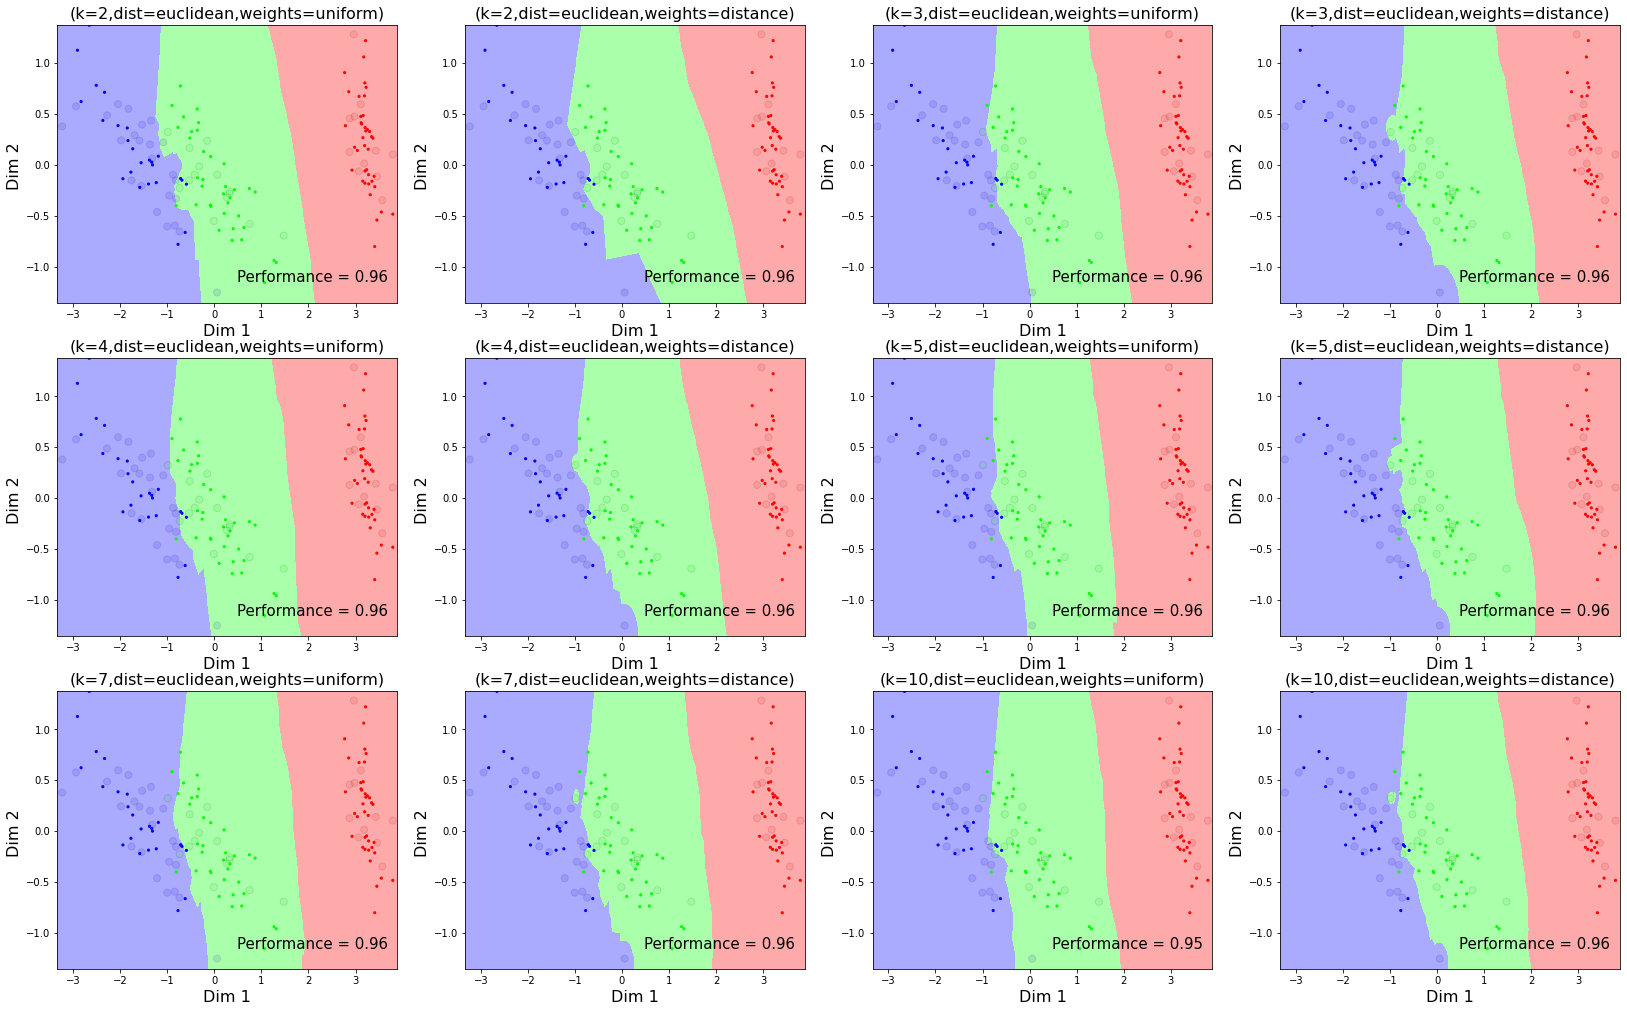

In [239]:
# créer la carte des couleurs utiliséesCreate color maps
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

figure = plt.figure(figsize=(28, 48))
for  i, knn in enumerate(les_classifieurs):
    score = knn.score(X_test_pca, target_test)
    configuration = lesConfigurations[i]
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #
    # affichage
    ax=plt.subplot(8,4,i+1)
    # # carte de classification
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # points de l'apprentissage
    ax.scatter(X_app_pca[:, 0], X_app_pca[:, 1], c=target_app,
               cmap=cmap_bold, edgecolor='k', s=50,alpha=.1)
    # points de test
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=target_test,
               cmap=cmap_bold, edgecolor='None', s=10)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Dim 1',fontsize=16)
    plt.ylabel('Dim 2 ',fontsize=16)
    plt.title("(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],
                                                    configuration['dist'],
                                                    configuration['weights']),
              fontsize=16)
    ax.text(xx.max() - .2, yy.min() + .2, ('Performance = %.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')


In [240]:
from sklearn.metrics import classification_report
for  i, knn in enumerate(les_classifieurs):
    y_predict=knn.predict(data_test)
    configuration = lesConfigurations[i]
    print("(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],configuration['dist'],
                                                    configuration['weights'])),
    print(classification_report(target_test, y_predict))

ValueError: query data dimension must match training data dimension

#### Affichage des matrices de confusion pour chacun des classifieurs (app)

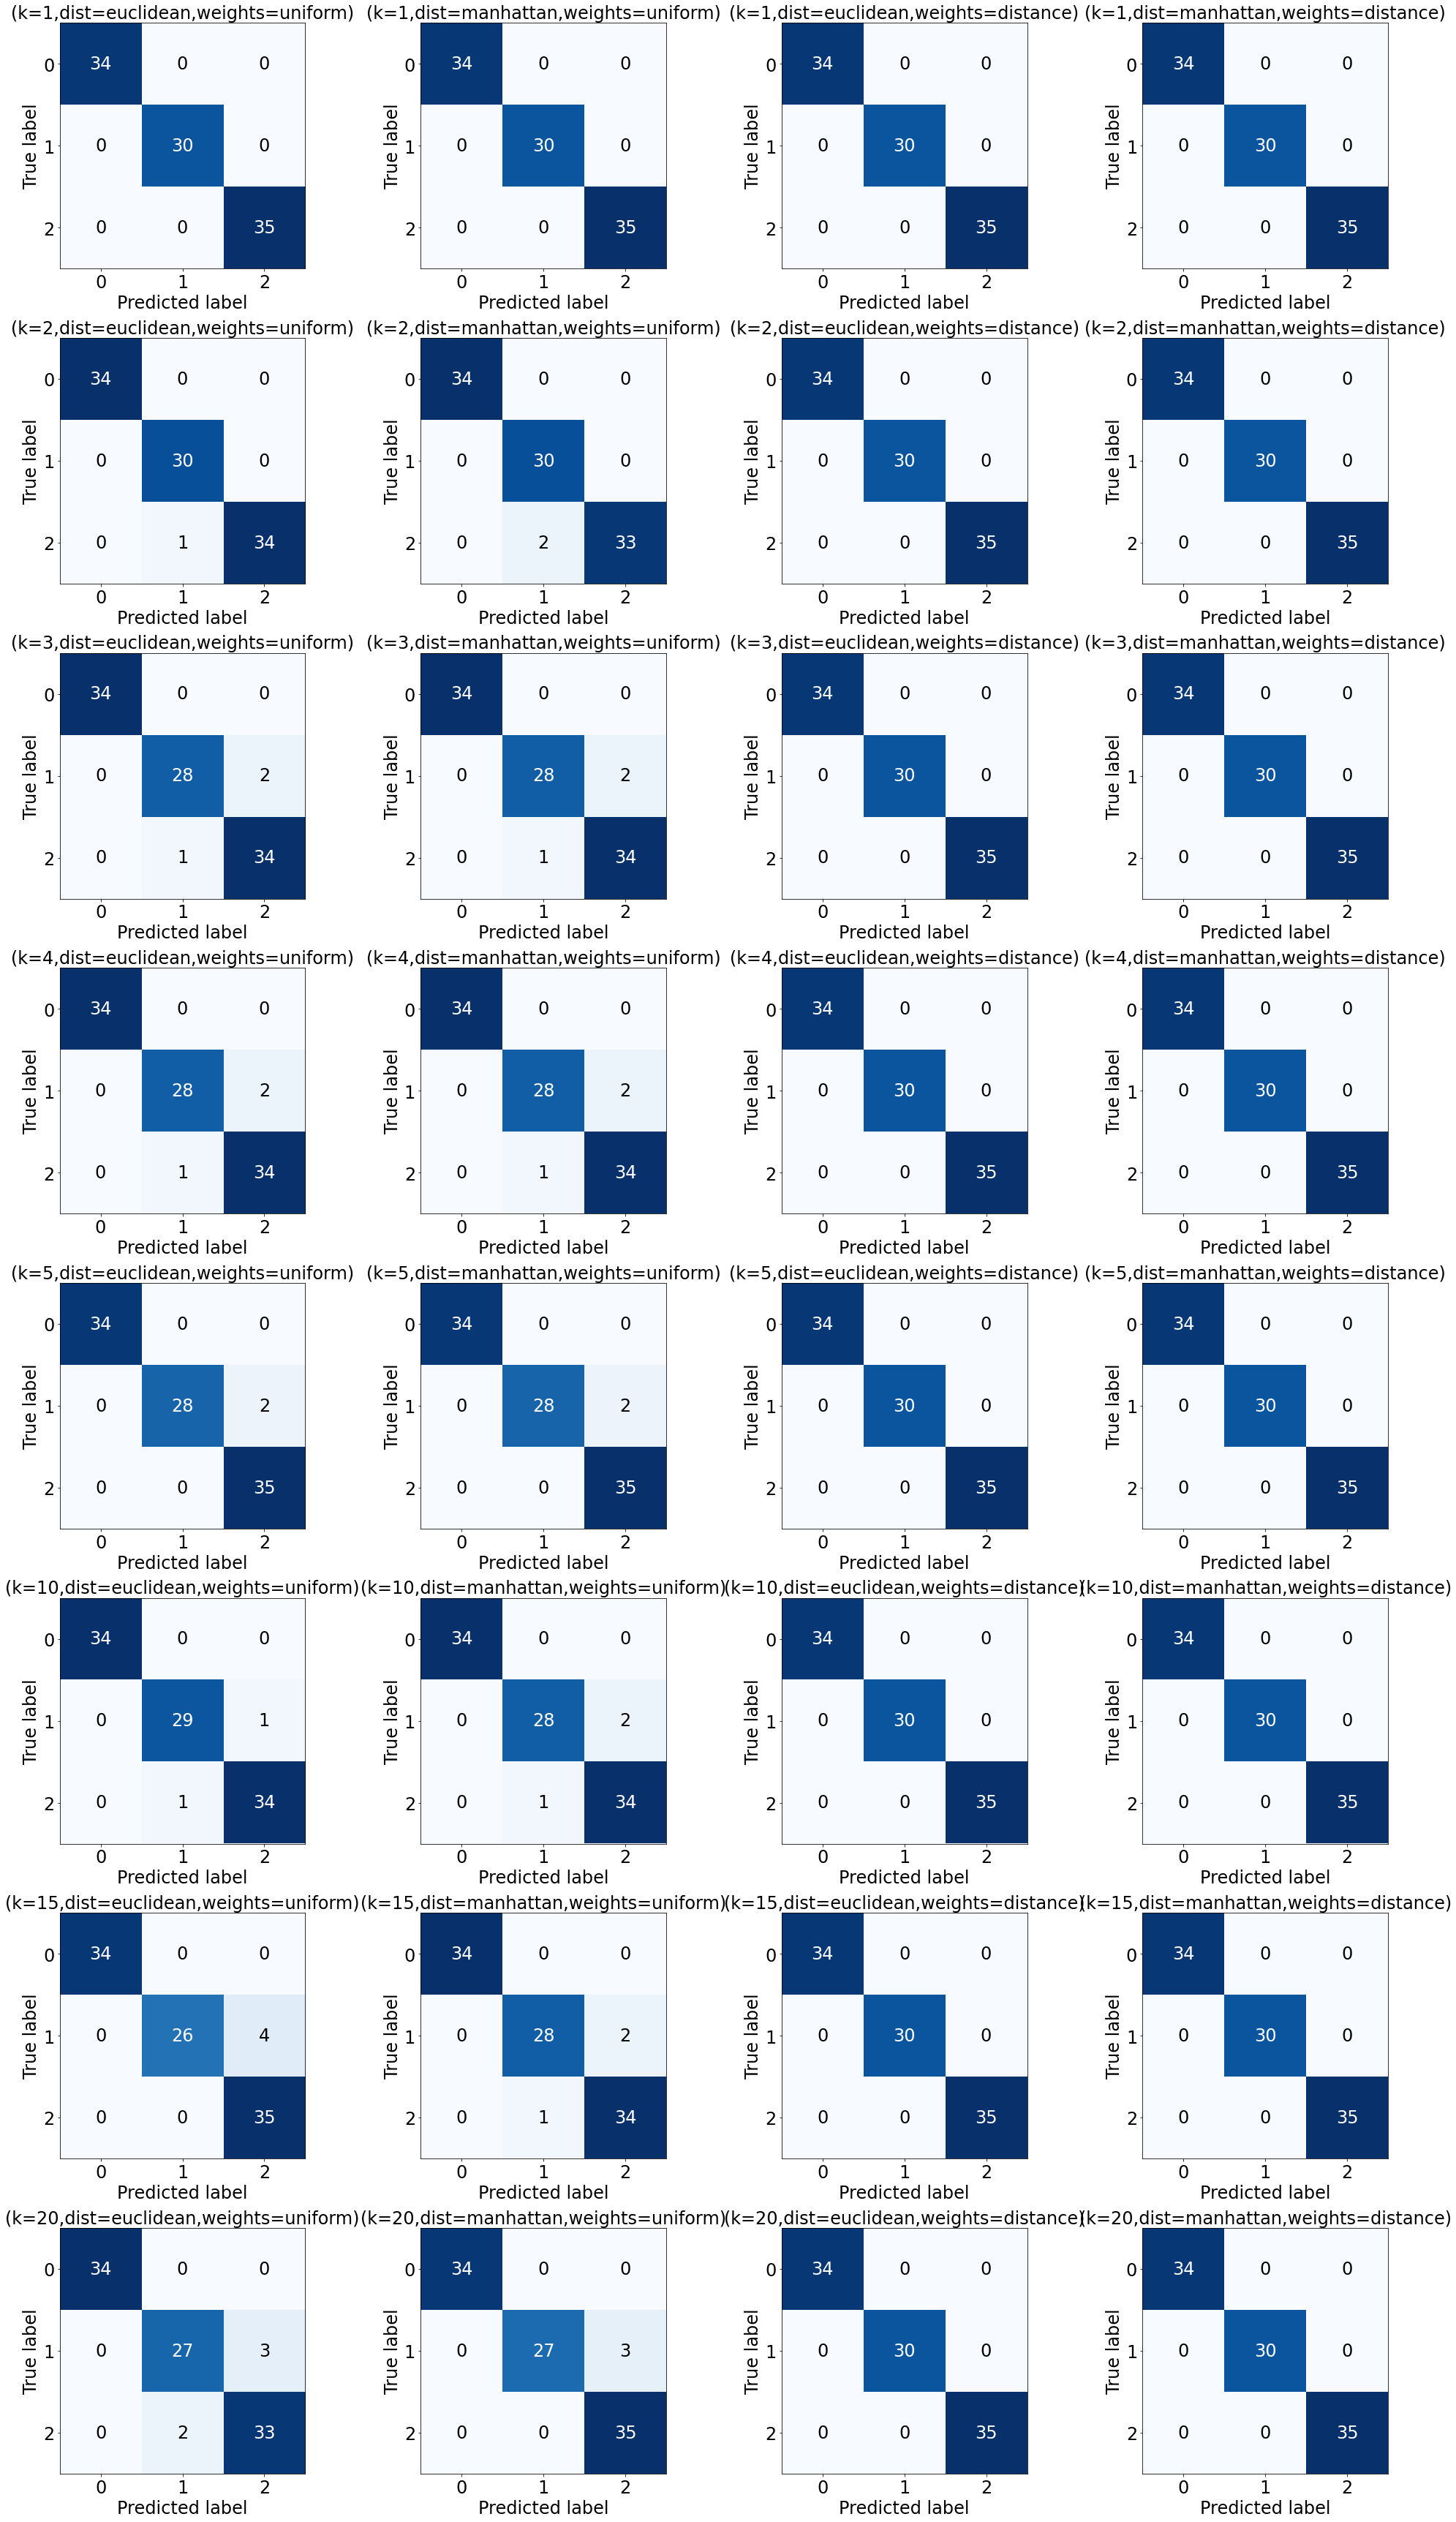

In [78]:
# créer la carte des couleurs utiliséesCreate color maps
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

figure = plt.figure(figsize=(28, 48))
for  i, knn in enumerate(les_classifieurs):
    score = knn.score(data_app, target_app)
    configuration = lesConfigurations[i]
    predict_app = knn.predict(data_app)
    #
    # affichage
    ax=plt.subplot(8,4,i+1)
    # titre
    titre = "(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],
                                                    configuration['dist'],
                                                    configuration['weights'])
    # matrice de confusion
    plot_confusion_matrix(target_app, predict_app, classes,
                          title=titre,fontsize=24)
plt.tight_layout()

#### Affichage des matrices de confusion pour chacun des classifieurs (test)

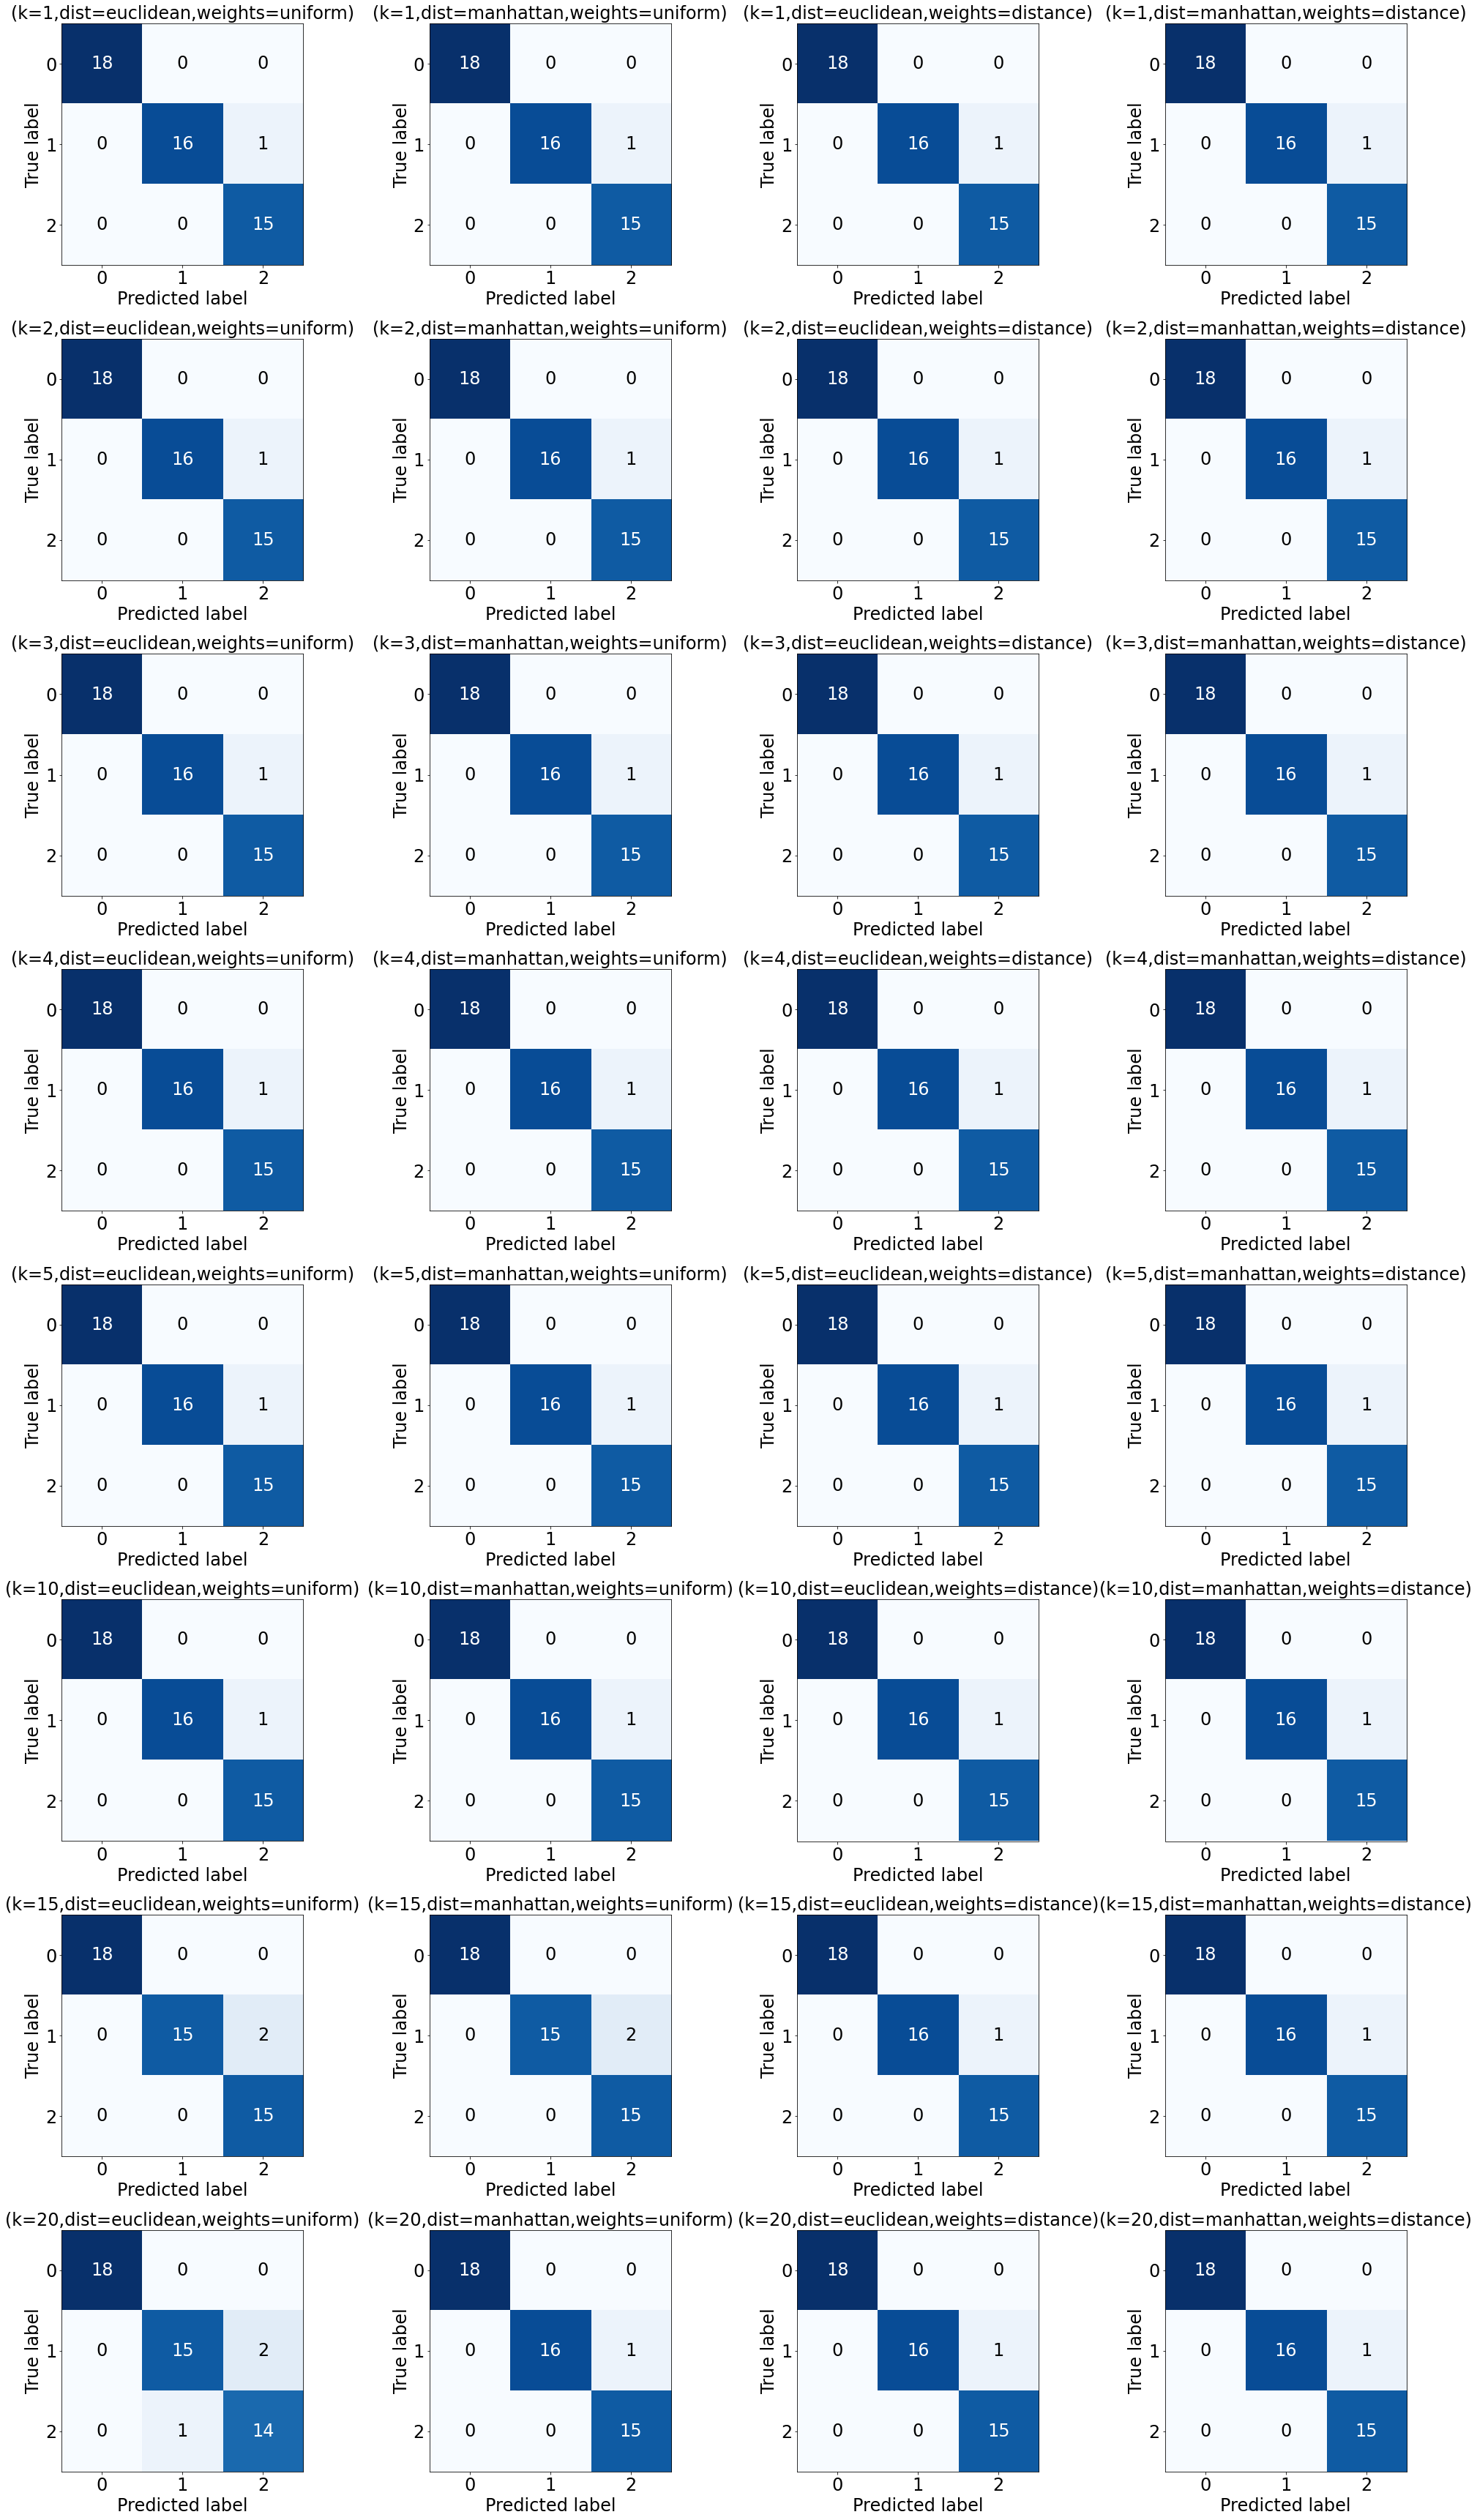

In [15]:
# créer la carte des couleurs utiliséesCreate color maps
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

figure = plt.figure(figsize=(28, 48))
for  i, knn in enumerate(les_classifieurs):
    score = knn.score(data_test, target_test)
    configuration = lesConfigurations[i]
    predict_test = knn.predict(data_test)
    #
    # affichage
    ax=plt.subplot(8,4,i+1)
    # titre
    titre = "(k={0},dist={1},weights={2})".format(configuration['n_neighbors'],
                                                    configuration['dist'],
                                                    configuration['weights'])
    # matrice de confusion
    plot_confusion_matrix(target_test, predict_test, classes,
                          title=titre,fontsize=24)
plt.tight_layout()

***
**On est jamais mieux servi que par soi-même.**  
**If you want something done right, do it yourself.**

[scipy](https://www.scipy.org/) - [pandas](https://pandas.pydata.org/) - [Numpy and Scipy](https://docs.scipy.org/doc/) - [matplotlib](https://matplotlib.org/) - [scikit-learn](http://scikit-learn.org/stable/) - [seaborn](https://seaborn.pydata.org/)